# Name

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi Zhou

## Content

## Method

## Toy Example

In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np
import time
from Inference import Inference
from Subspace import Subspace
from model import Model
from util import hidecode

from mpl_toolkits.mplot3d import Axes3D
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y=0.25)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 65.1166805377315; gradient mag: 164.7321094609157
Iteration 100 lower bound 52.86436046756695; gradient mag: 56.954586390884565
Iteration 200 lower bound 49.42633385370295; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.73326189562314; gradient mag: 18.311751879565836
Iteration 400 lower bound 46.647745693540806; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.88691542805831; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.97792508592485; gradient mag: 20.35417699419094
Iteration 900 lower bound 24.278363637665734; gradient mag: 18.779125916898224
Iteration 1000 lower bound 22.02986716940495; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.21045518866592
Iteration 1200 lower bound 18.434367471681025; gradient mag: 15.0920445

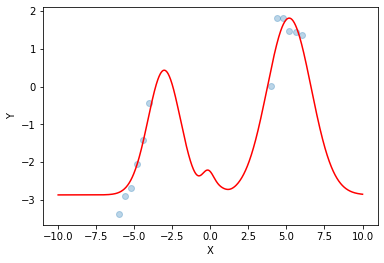

In [3]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y');

In [4]:
output_noise = 0.5**2
def log_likelihood(y_actual, y_pred):
    return -0.5 * np.log(2 * np.pi * output_noise) - 0.5 * np.mean(((y_actual - y_pred)**2).sum(axis = 1)) / output_noise

## random

In [44]:
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [45]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [46]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -193.31931666095662; gradient mag: 109.40731735896794
Iteration 200 lower bound -90.21775275531911; gradient mag: 17.326982603205924
Iteration 400 lower bound -72.52899957725451; gradient mag: 37.46440475553639
Iteration 600 lower bound -22.008031589691825; gradient mag: 20.087839629429897
Iteration 800 lower bound -13.047009067240277; gradient mag: 8.972712723928053
Iteration 1000 lower bound -10.599505649009837; gradient mag: 4.937316215296603
Iteration 1200 lower bound -9.659195724649464; gradient mag: 3.150948712222021
Iteration 1400 lower bound -9.252419102885161; gradient mag: 2.150793090538696
Iteration 1600 lower bound -8.917098532844648; gradient mag: 1.5514119908689237
Iteration 1800 lower bound -8.68411378627838; gradient mag: 1.3927255263853717
Iteration 2000 lower bound -8.595618637146343; gradient mag: 0.9961546072575298
Iteration 2200 lower bound -8.497965976873887; gradient mag: 0.7062575839609994
Iteration 2400 lower bound -8.431779662749786; gr

In [47]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 9.32 min


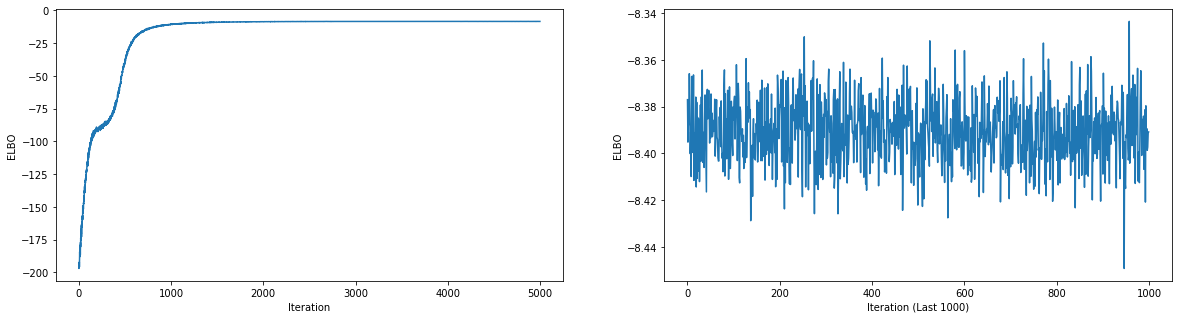

In [48]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(my_inference.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(my_inference.ELBO[-1000:])
ax[1].set_xlabel('Iteration (Last 1000)')
ax[1].set_ylabel('ELBO');

In [49]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

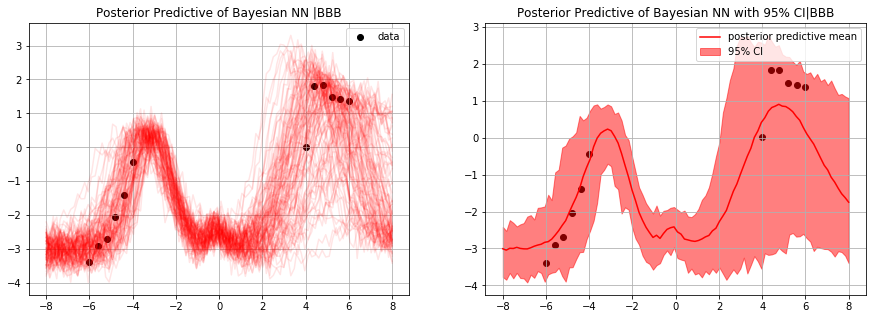

In [50]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

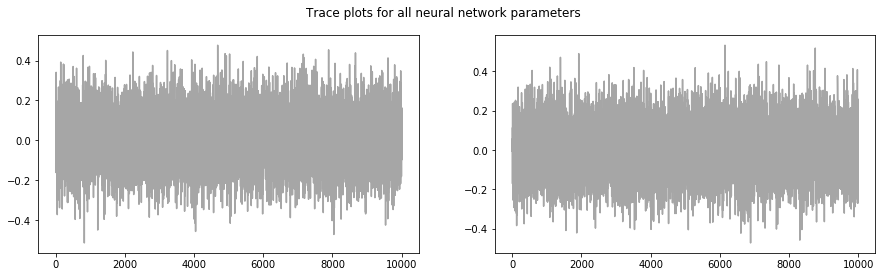

In [51]:
# check for convergence
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [52]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_random = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_random))

The Posterior Predictive Log likelihood of the observed data is -33.4643


posterior density

In [21]:
def plot_posterior_likelihood(my_inference,name,zx_range=[-0.2,0.2], zy_range=[-0.2,0.2]):
    zx=np.linspace(zx_range[0],zx_range[1],10)
    zy=np.linspace(zy_range[0],zy_range[1],10)
    zx,zy=np.meshgrid(zx,zy)
    z=np.array([zx,zy]).reshape(2,-1).T
    level = my_inference.get_posterior_likelihood(z=z,X=x,y=y).reshape(10,10)
    post_z=my_inference.get_posterior(50)
    post_level=my_inference.get_posterior_likelihood(z=post_z,X=x,y=y)
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(zx,zy,level,cmap='Reds', edgecolor='none')
    ax.scatter3D(post_z[:,0],post_z[:,1],post_level,label='chosed posterior z')
    plt.title('posterior log density ',fontsize=15)
    ax.set_xlabel('z 1')
    ax.set_ylabel('z 2')
    ax.set_zlabel('posterior log density')
    plt.legend(loc='lower left')
    ax1= fig.add_subplot(122)
    cs=ax1.contourf(zx, zy, level, levels=20, linewidths=1,cmap='Reds')
    ax1.scatter(post_z[:,0],post_z[:,1],label='chosed posterior z',s=5)
    fig.colorbar(cs, ax=ax1)
    plt.xlabel('z 1')
    plt.ylabel('z 2')
    plt.title('posterior log density ',fontsize=15)
    plt.legend()
    plt.suptitle(name, fontsize=20)

/Users/susanaxu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: linewidths is ignored by contourf


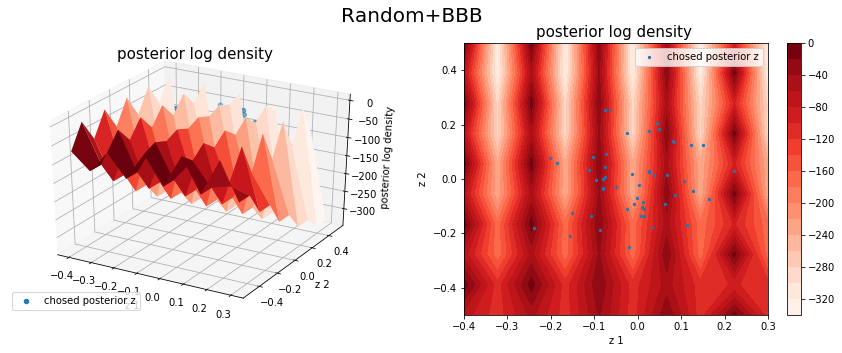

In [59]:
plot_posterior_likelihood(my_inference=my_inference, name='Random+BBB',zx_range=[-0.4,0.3], zy_range=[-0.5,0.5])

Notes: the blue points in BBB lies near the highest place, but not at the highest place.

## PCA

In [23]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [24]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [25]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=5)
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [26]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -15.281148235602133; gradient mag: 4.772889881790363
Iteration 200 lower bound -10.668284438554197; gradient mag: 3.8310108733805235
Iteration 400 lower bound -7.614380127248929; gradient mag: 2.9965357756826423
Iteration 600 lower bound -5.72497381187767; gradient mag: 2.321737930822825
Iteration 800 lower bound -4.402285744900138; gradient mag: 1.6895134158145582
Iteration 1000 lower bound -3.684586806107648; gradient mag: 1.1929098341183706
Iteration 1200 lower bound -3.282277819296061; gradient mag: 0.7912933654147407
Iteration 1400 lower bound -3.0987094372412636; gradient mag: 0.5652030991407123
Iteration 1600 lower bound -3.0156486866114705; gradient mag: 0.32457791801676616
Iteration 1800 lower bound -2.9625106146882394; gradient mag: 0.16017547052615386
Iteration 2000 lower bound -2.9720874231718986; gradient mag: 0.14857984409851285
Iteration 2200 lower bound -2.972496341439494; gradient mag: 0.04789098261750999
Iteration 2400 lower bound -2.9552383143

In [27]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 10.08 min


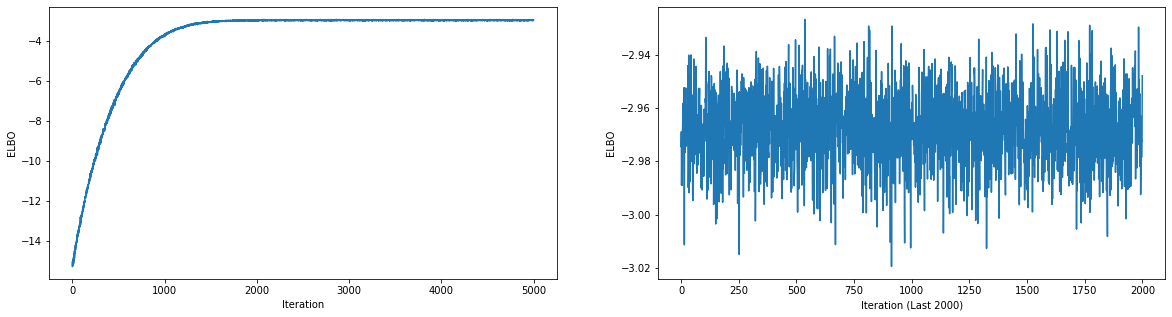

In [28]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(my_inference.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(my_inference.ELBO[-2000:])
ax[1].set_xlabel('Iteration (Last 2000)')
ax[1].set_ylabel('ELBO');

In [29]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

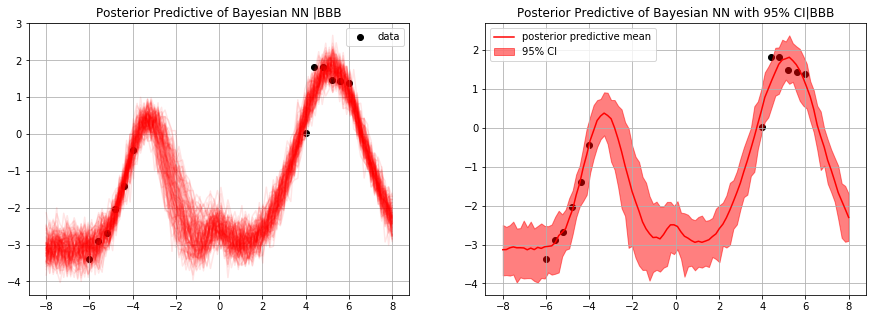

In [30]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

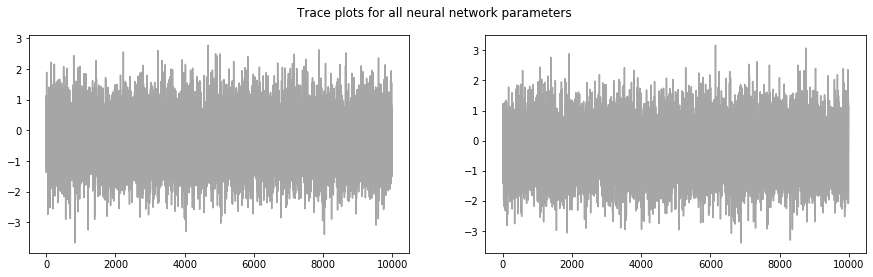

In [31]:
# check for convergence
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [32]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_pca = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_pca))

The Posterior Predictive Log likelihood of the observed data is -2.7449


/Users/susanaxu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: linewidths is ignored by contourf


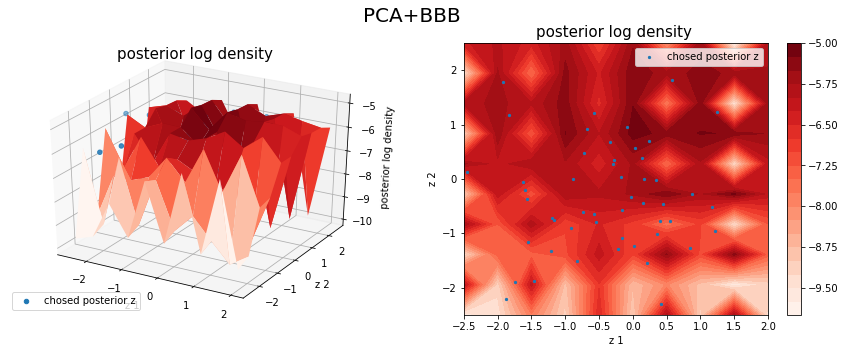

In [43]:
plot_posterior_likelihood(my_inference=my_inference, name='PCA+BBB',zx_range=[-2.5,2], zy_range=[-2.5,2.5])

## PCA (extension)

### the smallest deviations

In [4]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y, method='S') # chose the method as L
P, w = my_subspace.get_space()

In [6]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [7]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=5)
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [8]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -26.84587744389261; gradient mag: 9.123947310884923
Iteration 200 lower bound -18.181595534637253; gradient mag: 7.985910722190474
Iteration 400 lower bound -11.762881247843733; gradient mag: 6.442521957678777
Iteration 600 lower bound -7.617388553340697; gradient mag: 4.589879239749125
Iteration 800 lower bound -5.345924666255337; gradient mag: 3.195551288409141
Iteration 1000 lower bound -4.099960016033984; gradient mag: 2.0546461431749243
Iteration 1200 lower bound -3.516178867385201; gradient mag: 1.3195445222842268
Iteration 1400 lower bound -3.261096012876015; gradient mag: 0.7510749809718028
Iteration 1600 lower bound -3.20187944514491; gradient mag: 0.4123342329440724
Iteration 1800 lower bound -3.146621305004204; gradient mag: 0.20208219967084923
Iteration 2000 lower bound -3.1455260339754605; gradient mag: 0.10320579947881874
Iteration 2200 lower bound -3.1460281502742733; gradient mag: 0.07108958736686433
Iteration 2400 lower bound -3.1579999209751124

In [9]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 10.37 min


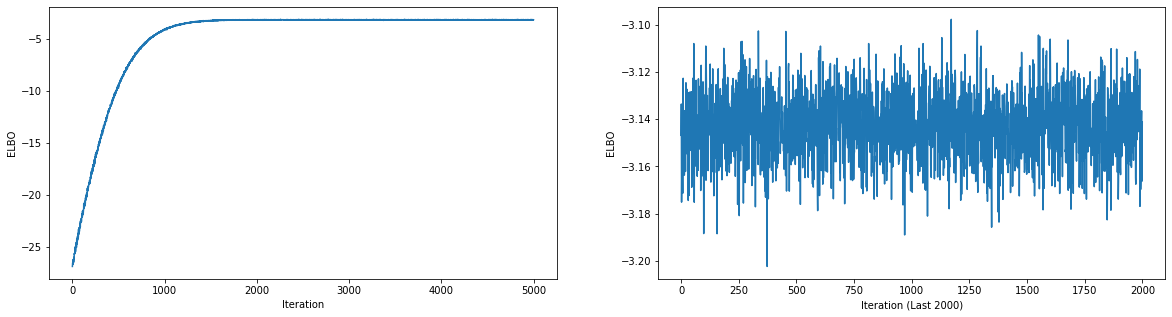

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(my_inference.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(my_inference.ELBO[-2000:])
ax[1].set_xlabel('Iteration (Last 2000)')
ax[1].set_ylabel('ELBO');

In [11]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

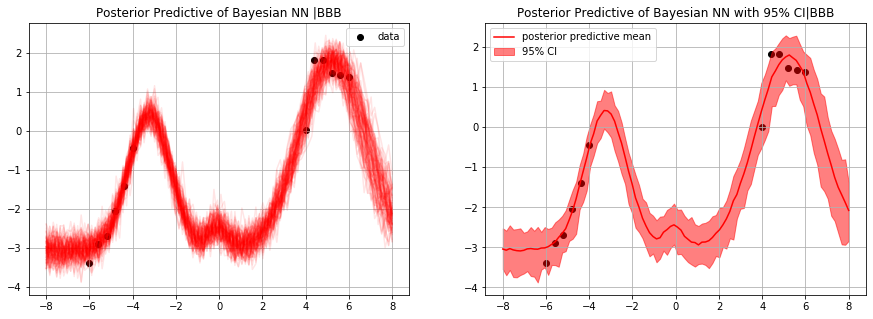

In [12]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

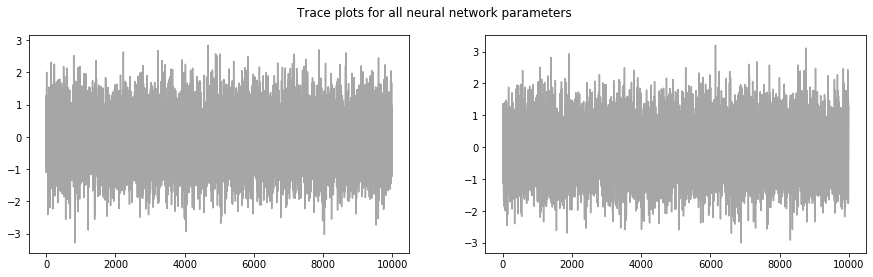

In [13]:
# check for convergence
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [15]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_pca_smallest = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_pca_smallest))

The Posterior Predictive Log likelihood of the observed data is -2.9177


### the largest deviations

In [16]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y, method='L') # chose the method as L
P, w = my_subspace.get_space()

In [17]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [18]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=5)
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [19]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -199.12934154078323; gradient mag: 82.03401247386195
Iteration 200 lower bound -157.1527919565324; gradient mag: 50.80702251359754
Iteration 400 lower bound -42.86363700908911; gradient mag: 46.21886306654061
Iteration 600 lower bound -16.495351484831204; gradient mag: 20.1321789517726
Iteration 800 lower bound -11.344672197307125; gradient mag: 8.698107712859672
Iteration 1000 lower bound -9.366659564856082; gradient mag: 8.958946126824687
Iteration 1200 lower bound -8.51987520246681; gradient mag: 5.686214839204961
Iteration 1400 lower bound -8.022688094962344; gradient mag: 6.480032400602905
Iteration 1600 lower bound -7.757357939613922; gradient mag: 4.290413330438235
Iteration 1800 lower bound -7.504616365745962; gradient mag: 3.057850267808513
Iteration 2000 lower bound -7.437425302962084; gradient mag: 4.826399937283748
Iteration 2200 lower bound -7.363482481150301; gradient mag: 3.0773683332255874
Iteration 2400 lower bound -7.261795069392591; gradient m

In [20]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 10.49 min


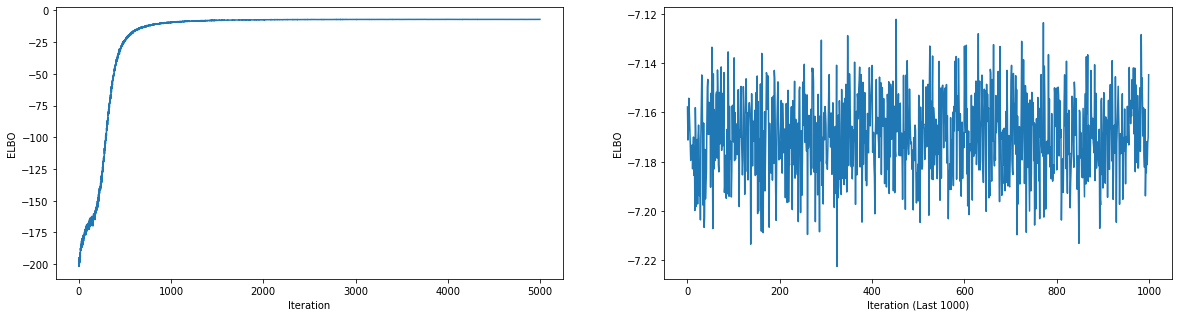

In [23]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(my_inference.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(my_inference.ELBO[-1000:])
ax[1].set_xlabel('Iteration (Last 1000)')
ax[1].set_ylabel('ELBO');

In [22]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

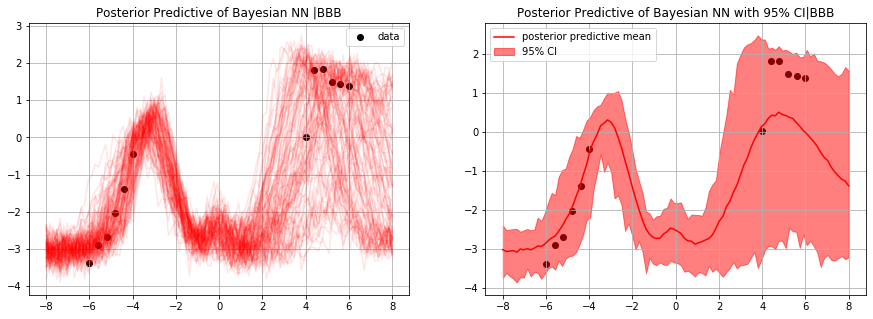

In [24]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

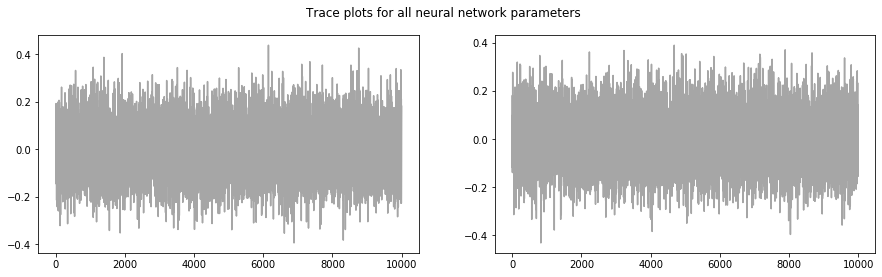

In [25]:
# check for convergence
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [26]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_pca_largest = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_pca_largest))

The Posterior Predictive Log likelihood of the observed data is -45.7271
